# RNNs and LSTM -  Synthetic Data

This notebook explores building synthetic sequential data with noise and  seasonality attributes, and using RNNs and LSTMs to predict future values.

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Create synthetic data

In [6]:
# create functions to synthesize data

# -- plots
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

# -- creates trends in series
def trend(time, slope=0):
    return slope * time

# -- creates an arbitrary seasonal pattern
def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

# -- repeats the same pattern at each period
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

# -- creates random noise
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
# define data attributes

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

In [8]:
# create series

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=51)  # add noise

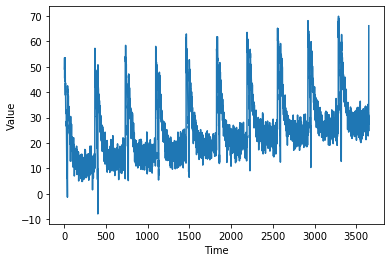

In [9]:
plot_series(time, series)

In [12]:
# define train and test split

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Windowed data

In [13]:
# define window size

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [14]:
# function to create windowed dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [15]:
# define windowed dataset

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Model
* **Notes**: 
    * Lambda layer was used to expand the dimensions by 1 (RNN expects 3 dimensions; batch size, the number of timestamps, and the series dimensionality)
    * Another lambda layer was used to scale the output value by 100 to increase accuracy (as the time-series values are in the 10s)

In [10]:
# define model architecture

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),           
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 10.0)
])

In [16]:
# check for multiple learning rates

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))  # increase learning rate each epoch
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 7s 76ms/step - loss: 18.7072 - mae: 19.0856
Epoch 2/100
94/94 [==============================] - 2s 23ms/step - loss: 18.6125 - mae: 19.0425
Epoch 3/100
94/94 [==============================] - 2s 23ms/step - loss: 18.5138 - mae: 18.9940
Epoch 4/100
94/94 [==============================] - 2s 23ms/step - loss: 18.4785 - mae: 18.9399
Epoch 5/100
94/94 [==============================] - 2s 24ms/step - loss: 18.4143 - mae: 18.8796
Epoch 6/100
94/94 [==============================] - 2s 24ms/step - loss: 18.2921 - mae: 18.8125
Epoch 7/100
94/94 [==============================] - 2s 24ms/step - loss: 18.2254 - mae: 18.7377
Epoch 8/100
94/94 [==============================] - 2s 23ms/step - loss: 18.1181 - mae: 18.6543
Epoch 9/100
94/94 [==============================] - 2s 23ms/step - loss: 18.0700 - mae: 18.5615
Epoch 10/100
94/94 [==============================] - 2s 24ms/step - loss: 17.9422 - mae: 18.4582
Epoch 11/100
94/94 [=========

94/94 [==============================] - 2s 22ms/step - loss: 3.0326 - mae: 3.5036
Epoch 86/100
94/94 [==============================] - 2s 24ms/step - loss: 3.0834 - mae: 3.5471
Epoch 87/100
94/94 [==============================] - 2s 25ms/step - loss: 3.0354 - mae: 3.4975
Epoch 88/100
94/94 [==============================] - 2s 22ms/step - loss: 3.1639 - mae: 3.6297
Epoch 89/100
94/94 [==============================] - 2s 23ms/step - loss: 3.0076 - mae: 3.4835
Epoch 90/100
94/94 [==============================] - 2s 23ms/step - loss: 3.2606 - mae: 3.7203
Epoch 91/100
94/94 [==============================] - 2s 23ms/step - loss: 3.2336 - mae: 3.6979
Epoch 92/100
94/94 [==============================] - 2s 23ms/step - loss: 3.0096 - mae: 3.4878
Epoch 93/100
94/94 [==============================] - 2s 23ms/step - loss: 2.9564 - mae: 3.4465
Epoch 94/100
94/94 [==============================] - 2s 23ms/step - loss: 3.0170 - mae: 3.5045
Epoch 95/100
94/94 [==============================] -

[1e-08, 0.0001, 0, 30]

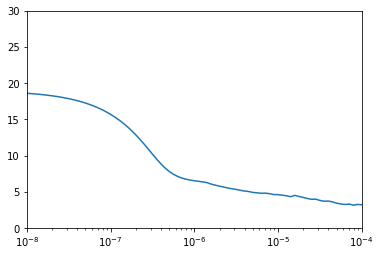

In [17]:
# plot learning rates

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

### Retry with optimal learning rate

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
94/94 [==============================] - 7s 73ms/step - loss: 317.3267 - mae: 10.6099
Epoch 2/500
94/94 [==============================] - 2s 23ms/step - loss: 38.8102 - mae: 4.1943
Epoch 3/500
94/94 [==============================] - 2s 24ms/step - loss: 33.0714 - mae: 3.9061
Epoch 4/500
94/94 [==============================] - 2s 24ms/step - loss: 28.5534 - mae: 3.5994
Epoch 5/500
94/94 [==============================] - 2s 22ms/step - loss: 31.2755 - mae: 3.8952
Epoch 6/500
94/94 [==============================] - 2s 23ms/step - loss: 27.3960 - mae: 3.5512
Epoch 7/500
94/94 [==============================] - 2s 26ms/step - loss: 26.2363 - mae: 3.4617
Epoch 8/500
94/94 [==============================] - 2s 24ms/step - loss: 30.7583 - mae: 3.8562
Epoch 9/500
94/94 [==============================] - 2s 23ms/step - loss: 28.1299 - mae: 3.6017
Epoch 10/500
94/94 [==============================] - 2s 24ms/step - loss: 29.8303 - mae: 3.8047
Epoch 11/500
94/94 [=================

94/94 [==============================] - 2s 24ms/step - loss: 22.8103 - mae: 3.2693
Epoch 86/500
94/94 [==============================] - 2s 24ms/step - loss: 21.7443 - mae: 3.1244
Epoch 87/500
94/94 [==============================] - 2s 24ms/step - loss: 22.6609 - mae: 3.1994
Epoch 88/500
94/94 [==============================] - 2s 24ms/step - loss: 24.1893 - mae: 3.4071
Epoch 89/500
94/94 [==============================] - 2s 23ms/step - loss: 21.8825 - mae: 3.1387
Epoch 90/500
94/94 [==============================] - 2s 24ms/step - loss: 23.5016 - mae: 3.2741
Epoch 91/500
94/94 [==============================] - 2s 22ms/step - loss: 22.6872 - mae: 3.2437
Epoch 92/500
94/94 [==============================] - 2s 23ms/step - loss: 22.9603 - mae: 3.2601
Epoch 93/500
94/94 [==============================] - 2s 24ms/step - loss: 23.0041 - mae: 3.2594
Epoch 94/500
94/94 [==============================] - 2s 23ms/step - loss: 22.0054 - mae: 3.1581
Epoch 95/500
94/94 [=======================

94/94 [==============================] - 2s 24ms/step - loss: 20.8966 - mae: 3.0795
Epoch 169/500
94/94 [==============================] - 2s 24ms/step - loss: 21.1165 - mae: 3.1363
Epoch 170/500
94/94 [==============================] - 2s 24ms/step - loss: 20.7970 - mae: 3.0764
Epoch 171/500
94/94 [==============================] - 2s 25ms/step - loss: 20.2494 - mae: 3.0223
Epoch 172/500
94/94 [==============================] - 2s 24ms/step - loss: 20.8935 - mae: 3.0938
Epoch 173/500
94/94 [==============================] - 2s 24ms/step - loss: 20.1973 - mae: 3.0033
Epoch 174/500
94/94 [==============================] - 2s 25ms/step - loss: 20.4067 - mae: 3.0208
Epoch 175/500
94/94 [==============================] - 2s 24ms/step - loss: 20.6302 - mae: 3.0750
Epoch 176/500
94/94 [==============================] - 2s 24ms/step - loss: 20.6704 - mae: 3.0844
Epoch 177/500
94/94 [==============================] - 2s 25ms/step - loss: 20.8026 - mae: 3.0946
Epoch 178/500
94/94 [=============

94/94 [==============================] - 2s 25ms/step - loss: 20.2156 - mae: 3.0014
Epoch 252/500
94/94 [==============================] - 2s 23ms/step - loss: 20.7971 - mae: 3.1064
Epoch 253/500
94/94 [==============================] - 2s 24ms/step - loss: 21.1073 - mae: 3.0715
Epoch 254/500
94/94 [==============================] - 2s 24ms/step - loss: 20.1917 - mae: 2.9903
Epoch 255/500
94/94 [==============================] - 2s 25ms/step - loss: 20.0015 - mae: 2.9854
Epoch 256/500
94/94 [==============================] - 2s 24ms/step - loss: 20.4625 - mae: 3.0651
Epoch 257/500
94/94 [==============================] - 2s 24ms/step - loss: 20.6590 - mae: 3.0462
Epoch 258/500
94/94 [==============================] - 2s 25ms/step - loss: 20.3560 - mae: 3.0352
Epoch 259/500
94/94 [==============================] - 2s 26ms/step - loss: 20.1185 - mae: 2.9619
Epoch 260/500
94/94 [==============================] - 2s 25ms/step - loss: 20.9900 - mae: 3.0915
Epoch 261/500
94/94 [=============

94/94 [==============================] - 2s 22ms/step - loss: 20.4519 - mae: 3.0269
Epoch 335/500
94/94 [==============================] - 2s 24ms/step - loss: 20.8417 - mae: 3.0924
Epoch 336/500
94/94 [==============================] - 2s 24ms/step - loss: 20.0627 - mae: 3.0260
Epoch 337/500
94/94 [==============================] - 2s 24ms/step - loss: 19.9868 - mae: 3.0029
Epoch 338/500
94/94 [==============================] - 2s 24ms/step - loss: 19.9737 - mae: 2.9751
Epoch 339/500
94/94 [==============================] - 2s 26ms/step - loss: 19.4479 - mae: 2.9169
Epoch 340/500
94/94 [==============================] - 2s 22ms/step - loss: 20.1823 - mae: 3.0045
Epoch 341/500
94/94 [==============================] - 2s 23ms/step - loss: 20.4079 - mae: 3.0369
Epoch 342/500
94/94 [==============================] - 2s 23ms/step - loss: 19.5784 - mae: 2.9437
Epoch 343/500
94/94 [==============================] - 2s 24ms/step - loss: 19.5053 - mae: 2.9311
Epoch 344/500
94/94 [=============

94/94 [==============================] - 2s 23ms/step - loss: 20.0046 - mae: 2.9557
Epoch 418/500
94/94 [==============================] - 2s 23ms/step - loss: 20.0486 - mae: 3.0012
Epoch 419/500
94/94 [==============================] - 2s 24ms/step - loss: 19.4765 - mae: 2.9308
Epoch 420/500
94/94 [==============================] - 2s 24ms/step - loss: 19.8192 - mae: 2.9668
Epoch 421/500
94/94 [==============================] - 2s 23ms/step - loss: 19.7327 - mae: 2.9809
Epoch 422/500
94/94 [==============================] - 2s 23ms/step - loss: 20.4556 - mae: 3.0400
Epoch 423/500
94/94 [==============================] - 2s 24ms/step - loss: 19.5230 - mae: 2.9492
Epoch 424/500
94/94 [==============================] - 2s 25ms/step - loss: 19.7284 - mae: 2.9634
Epoch 425/500
94/94 [==============================] - 2s 26ms/step - loss: 20.5014 - mae: 3.0568
Epoch 426/500
94/94 [==============================] - 2s 23ms/step - loss: 20.1319 - mae: 3.0081
Epoch 427/500
94/94 [=============

94/94 [==============================] - 2s 24ms/step - loss: 20.5952 - mae: 3.0503


## Results

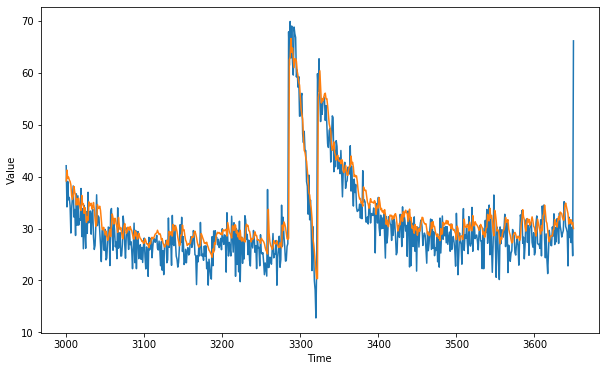

In [19]:
# plot forecast vs actual data

# -- get forecast results
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
# mean absolute error as a measure of accuracy

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.3967519

<Figure size 432x288 with 0 Axes>

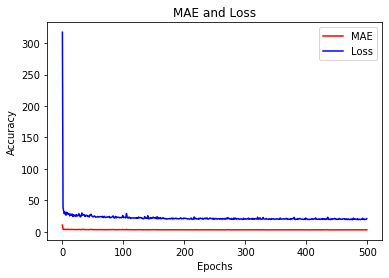

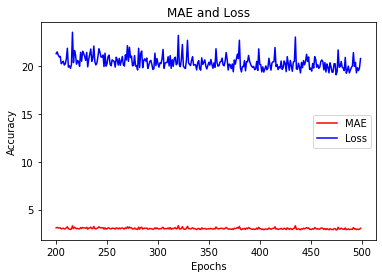

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

# plot MAE and loss
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]


# plot zoomed MAE and loss
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()